# Definition
**popularity:** ratio of positive reviews over the total number of reviews toward a subject. (How much are they liked?)

**fame:** number of revews towards a subject. (How many people know them?)

# Load datasets

In [1]:
# Necessary libraries import
import pandas as pd
import numpy as np

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# This discards edges than have the same source and destination. 
# In practice, it removes only edges in the wikipedia dataset.
def drop_duplicate_edge(df):
    df.drop_duplicates(subset=['FromNodeId', 'ToNodeId'], inplace=True)

# Read one of epinions or slashdot dataset, given the path.
def read_preprocessed_data(path, with_date):
    # The file is tab-separated and comments are marked with `#`
    # The header is actually a comment in the file, so we give it directly to read_csv
    columns = ['FromNodeId', 'ToNodeId', 'Sign']
    date = []
    if with_date:
        date.append('Date')
    df = pd.read_csv(path, sep='\t', comment='#', names=columns + date, parse_dates=date)
    drop_duplicate_edge(df)
    return df

epinions_df = read_preprocessed_data('data/soc-sign-epinions.txt', with_date=True)
slashdot_df = read_preprocessed_data('data/soc-sign-Slashdot090221.txt', with_date=False)
# Check that epinions was read correctly
epinions_df.head()

,FromNodeId,ToNodeId,Sign,Date
0,3287060356,232085,-1,2001-01-10
1,3288305540,709420,1,2001-01-10
2,3290337156,204418,-1,2001-01-10
3,3294138244,269243,-1,2001-01-10
4,3294138244,170692484,-1,2001-01-10


In [3]:
# Check that slashdot was read correctly
slashdot_df.head()

,FromNodeId,ToNodeId,Sign
0,0,1,1
1,0,2,1
2,0,3,1
3,0,4,1
4,0,5,1


In [4]:
# Read and parse wikipedia dataset to be in the same format than the other two datasets
def parse_wiki(path):
    data = []
    # Ignore the encoding errors, as they are in usernames or other data that are not interesting to us
    with open(path, 'r', encoding='utf-8', errors='ignore') as fp:
        toNodeId = None  # Target of the elecion
        date = None
        for line in fp:
            if line.startswith('#'):  # Ignore comments
                continue
            splt = line.strip().split('\t')
            if   splt[0] == 'U':  # New target of the election
                toNodeId = int(splt[1])
            elif splt[0] == 'T':  # Date of the election
                date = pd.to_datetime(splt[1])
            elif splt[0] == 'V':  # New vote
                fromId = int(splt[2])
                vote = int(splt[1])
                if vote == 0:  # Drop netural votes, as they are not used in the paper
                    continue
                edge = (fromId, toNodeId, vote, date)
                data.append(edge)
    # Create a dataframe from the constructed edges
    df = pd.DataFrame(data, columns=['FromNodeId', 'ToNodeId', 'Sign', 'Date'])
    drop_duplicate_edge(df)
    return df

wikipedia_df = parse_wiki('data/wikiElec.ElecBs3.txt')
wikipedia_df.head()

,FromNodeId,ToNodeId,Sign,Date
0,3,30,1,2004-09-21 01:15:53
1,25,30,-1,2004-09-21 01:15:53
2,4,30,1,2004-09-21 01:15:53
3,5,30,1,2004-09-21 01:15:53
4,6,30,1,2004-09-21 01:15:53


In [5]:
# Store the datasets into datastructures that can hold other attributes too
wikipedia = {'df': wikipedia_df, 'name': 'Wikipedia'}
epinions = {'df': epinions_df, 'name': 'Epinions'}
slashdot = {'df': slashdot_df, 'name': 'Slashdot'}
datasets = [wikipedia, epinions, slashdot]
dated_datasets = [wikipedia, epinions]

# Popularity with respect to fame

In [6]:
def fame_and_popularity(df):
    df = df.groupby(['ToNodeId', 'Sign']).count()#.reset_index()
    df = pd.pivot_table(df, index='ToNodeId', values='FromNodeId', columns=['Sign'], fill_value=0)
    df.columns.name = None
    df['fame'] = df[-1] + df[1]
    df['popularity'] = df[1] / (df[-1] + df[1])
    return df

for dataset in datasets:
    dataset['fame_pop'] = fame_and_popularity(dataset['df'])

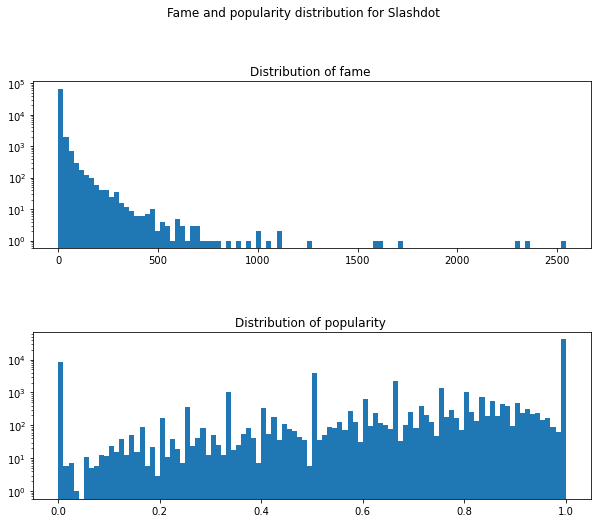

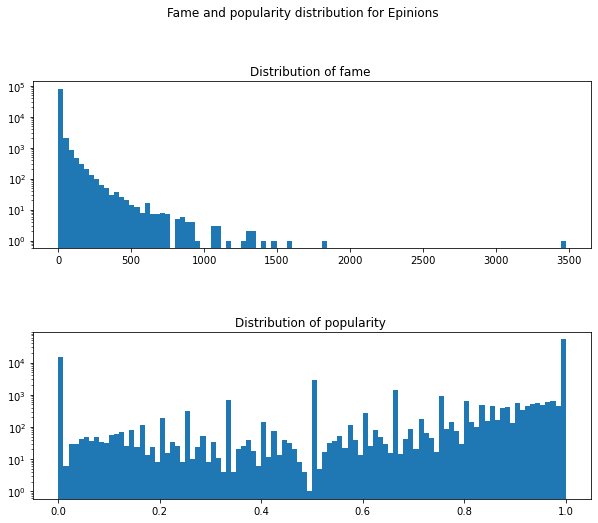

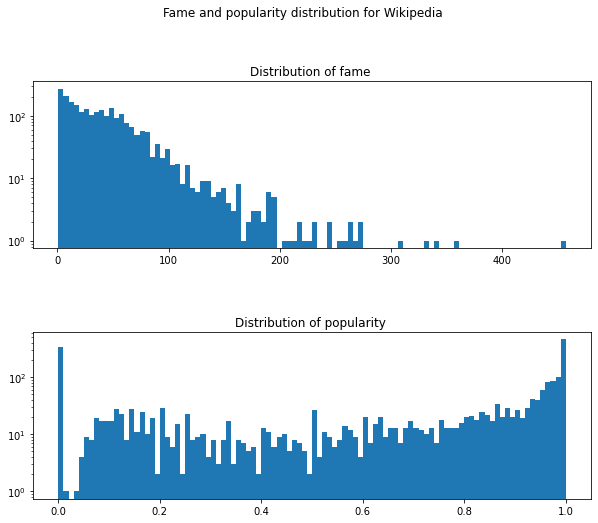

In [7]:
def plot_fame_and_pop(dataset):
    fame_and_pop = dataset['fame_pop']
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,8))
    fig.suptitle(f'Fame and popularity distribution for {dataset["name"]}')

    ax1.hist(data=fame_and_pop, x='fame', bins=100)
    ax1.set_title("Distribution of fame ")
    ax1.set_yscale('log')

    ax2.hist(data=fame_and_pop, x='popularity', bins=100)
    ax2.set_title("Distribution of popularity ")
    ax2.set_yscale('log')


    plt.subplots_adjust(top = 0.85, hspace=0.5)
    plt.show()
plot_fame_and_pop(slashdot)
plot_fame_and_pop(epinions)
plot_fame_and_pop(wikipedia)

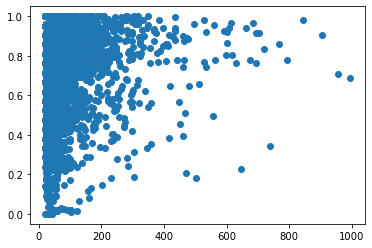

In [8]:
def plot_fame_vs_pop(dataset):
    fame_pop = dataset['fame_pop']
    fame_pop = fame_pop[(fame_pop.fame < 1000) & (fame_pop.fame > 20)]
    plt.scatter(fame_pop.fame, fame_pop.popularity)
    plt.show()
plot_fame_vs_pop(slashdot)

# Time analysis

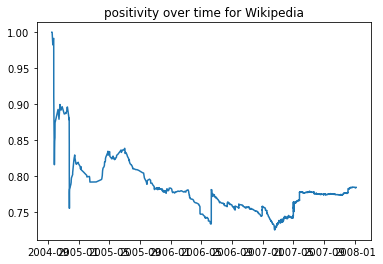

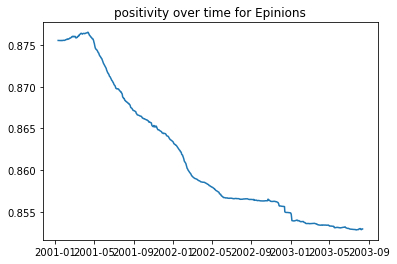

In [9]:
def positivity_over_time(df):
    df = df.copy()
    df['-1'] = (df['Sign'] == -1).astype(int)
    df['+1'] = (df['Sign'] == +1).astype(int)
    df = df[['Date', '-1', '+1']]
    df = df.groupby('Date').sum().sort_values(by='Date').copy()
    df['cumulative_+1'] = None
    df['cumulative_-1'] = None
    sum_p = 0; sum_n = 0
    for index, row in df.iterrows():
        sum_p += row['+1']
        sum_n += row['-1']

        df.at[index, 'cumulative_+1'] = sum_p
        df.at[index, 'cumulative_-1'] = sum_n
    df['positivity'] = df['cumulative_+1'] / (df['cumulative_+1'] + df['cumulative_-1'])
    return df
    
for d in dated_datasets:
    plt.plot(positivity_over_time(d['df'])['positivity'])
    plt.title(f'positivity over time for {d["name"]}')
    plt.show()

## Fame and popularity distribution over time

<IPython.core.display.Javascript object>


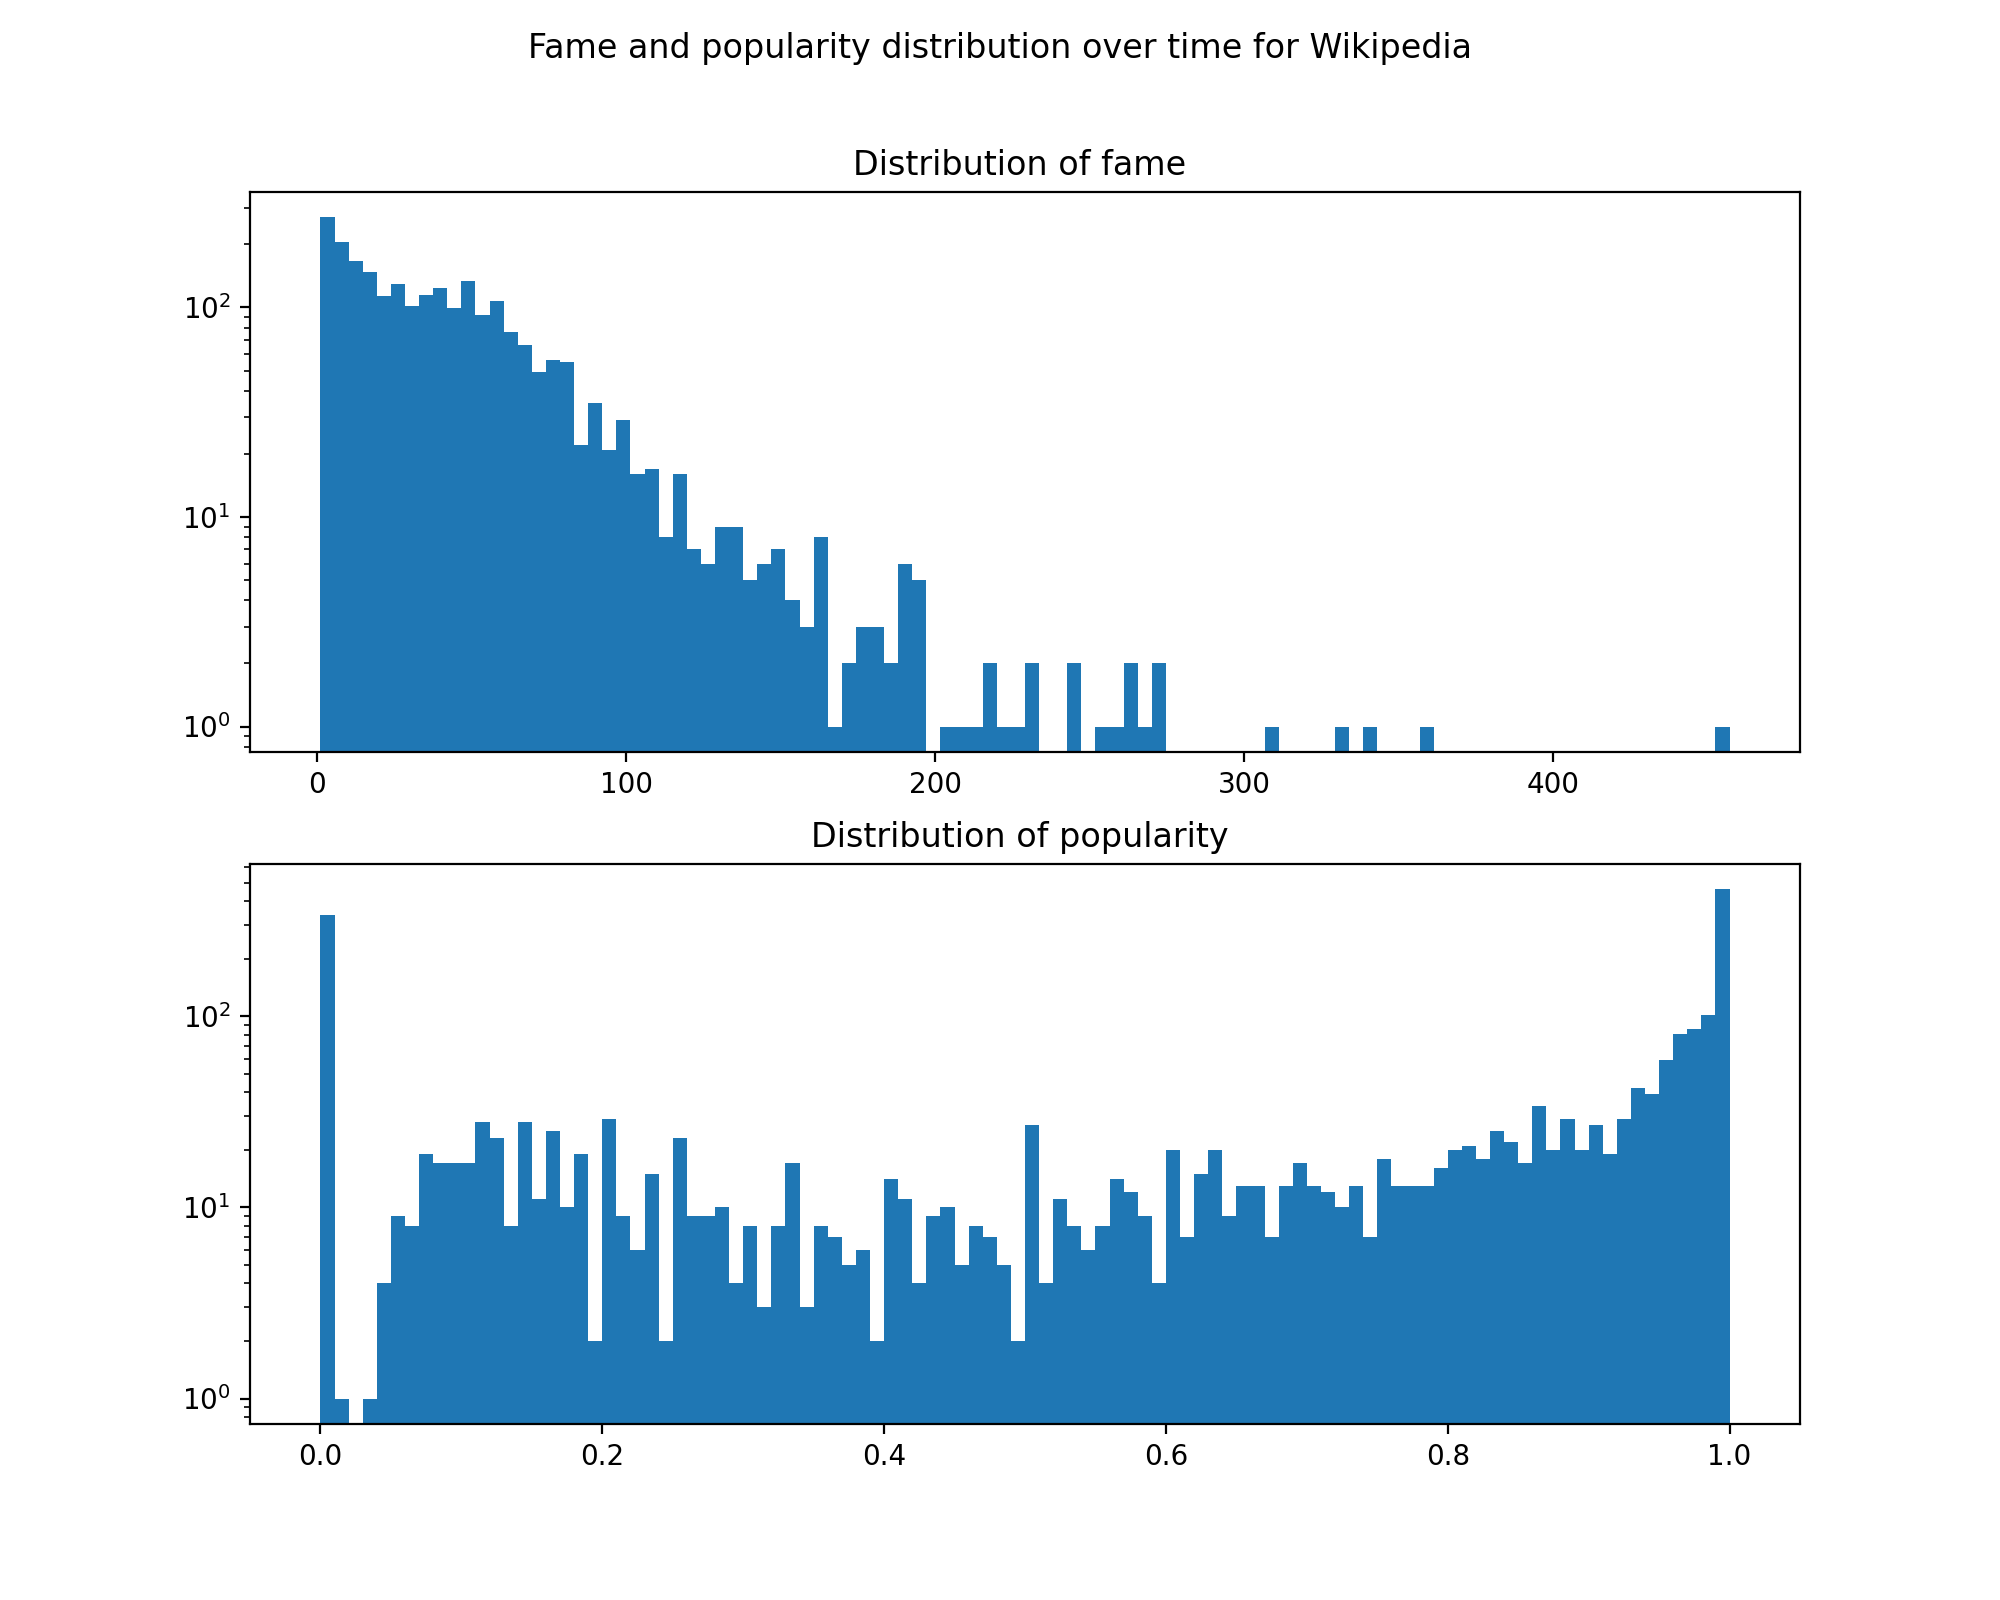

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 1206), layout=Layout(width='500px'),…

<IPython.core.display.Javascript object>


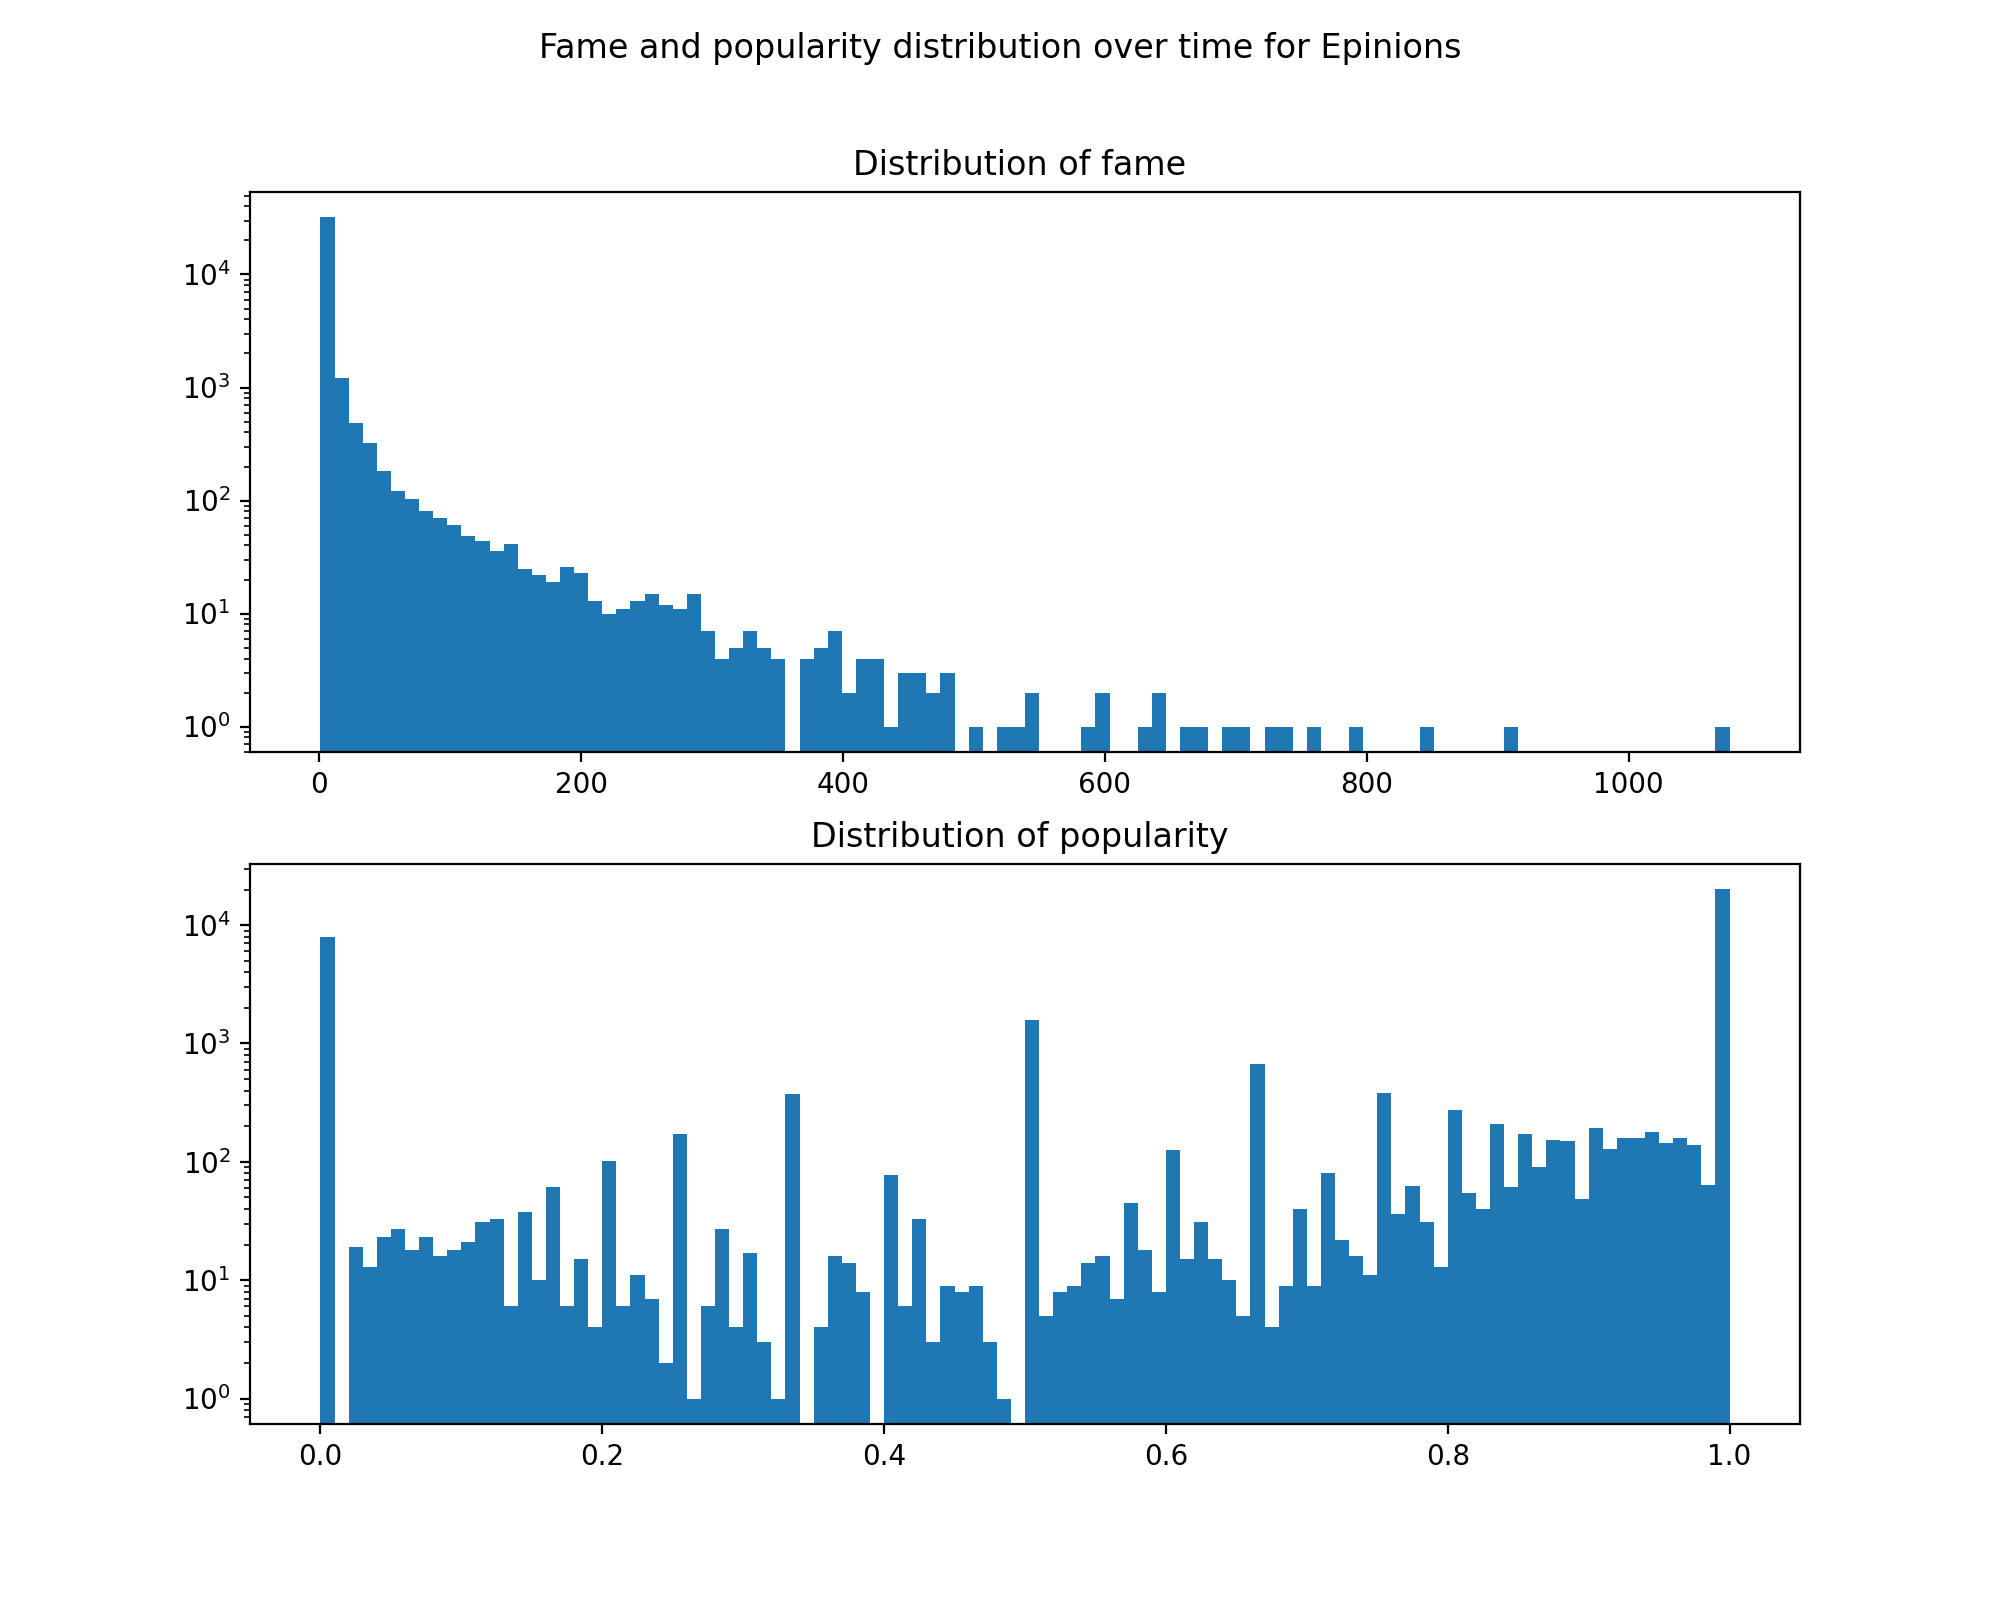

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 944), layout=Layout(width='500px'), …

In [16]:
%matplotlib notebook
from ipywidgets import *

def distribution_over_time(dataset):
    df = dataset['df']

    dates = pd.date_range(df.Date.min(), df.Date.max(), freq='D')
    

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,8))
    fig.suptitle(f'Fame and popularity distribution over time for {dataset["name"]}')
    
    def update(dates):
        new_data = fame_and_popularity(df[(df.Date > dates[0]) & (df.Date < dates[1])])
        ax1.cla()
        ax1.set_title("Distribution of fame ")
        ax1.hist(data=new_data, x='fame', bins=100)
        ax1.set_yscale('log')
        ax2.cla()
        ax2.hist(data=new_data, x='popularity', bins=100)
        ax2.set_title("Distribution of popularity ")
        ax2.set_yscale('log')
        plt.draw()
        
    options = [(date.strftime(' %d %b %Y '), date) for date in dates]
    index = (0, len(options)-1)

    selection_range_slider = widgets.SelectionRangeSlider(
        options=options,
        index=index,
        description='Dates',
        orientation='horizontal',
        layout={'width': '500px'}
    )

    interact(update, dates=selection_range_slider);

for d in dated_datasets:
    distribution_over_time(d)

## Evolution of the most famous subjects

<IPython.core.display.Javascript object>


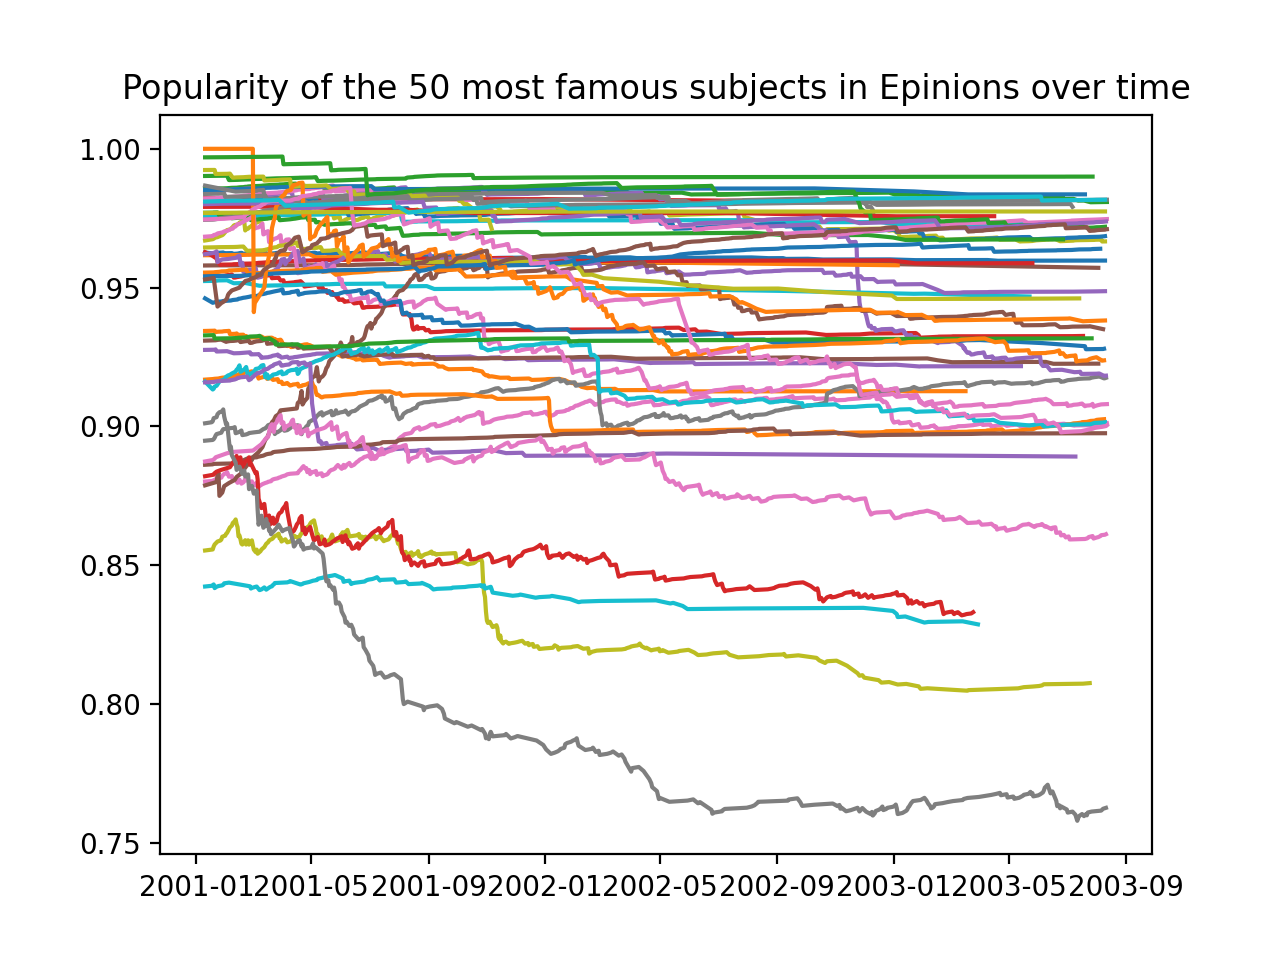

<IPython.core.display.Javascript object>


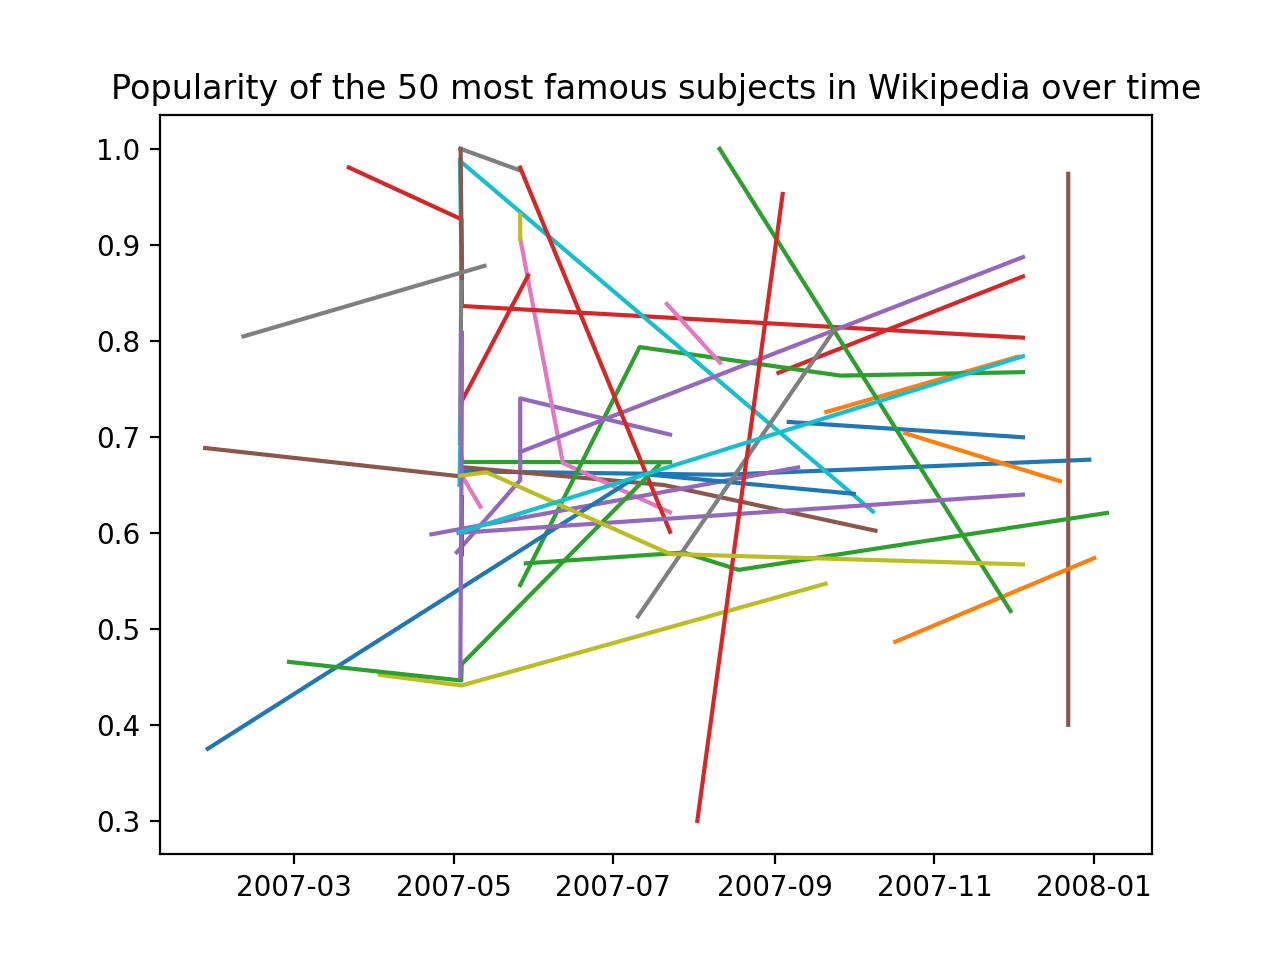

In [15]:
def top_k_evolution(dataset, k=50, start_date=pd.to_datetime('1970')):
    fame = dataset['fame_pop']
    most_famous = fame.nlargest(k, 'fame')
    df = dataset['df']
    plt.figure()
    for nodeId in most_famous.index:
        filtered = df[df.ToNodeId == nodeId]
        pos = positivity_over_time(filtered)
        pos = pos[pos.index > start_date]
        plt.plot(pos['positivity'])
    plt.title(f'Popularity of the {k} most famous subjects in {dataset["name"]} over time')
    plt.show()
top_k_evolution(epinions)
top_k_evolution(wikipedia, start_date=pd.to_datetime('2007'))

# Haters and Lovers

In [22]:
## Distrbution of the repartition of the signs from a user
def source_aggregate(dataset):
    df = dataset['df']
    df = df.groupby(['FromNodeId', 'Sign']).count()#.reset_index()
    df = pd.pivot_table(df, index='FromNodeId', values='ToNodeId', columns=['Sign'], fill_value=0)
    df.columns.name = None
    df['total_reviews'] = df[-1] + df[1]
    df['hater'] = df[-1] / df['total_reviews']
    dataset['source'] = df
    return df
    
for d in datasets:
    source_aggregate(d)
    

<IPython.core.display.Javascript object>


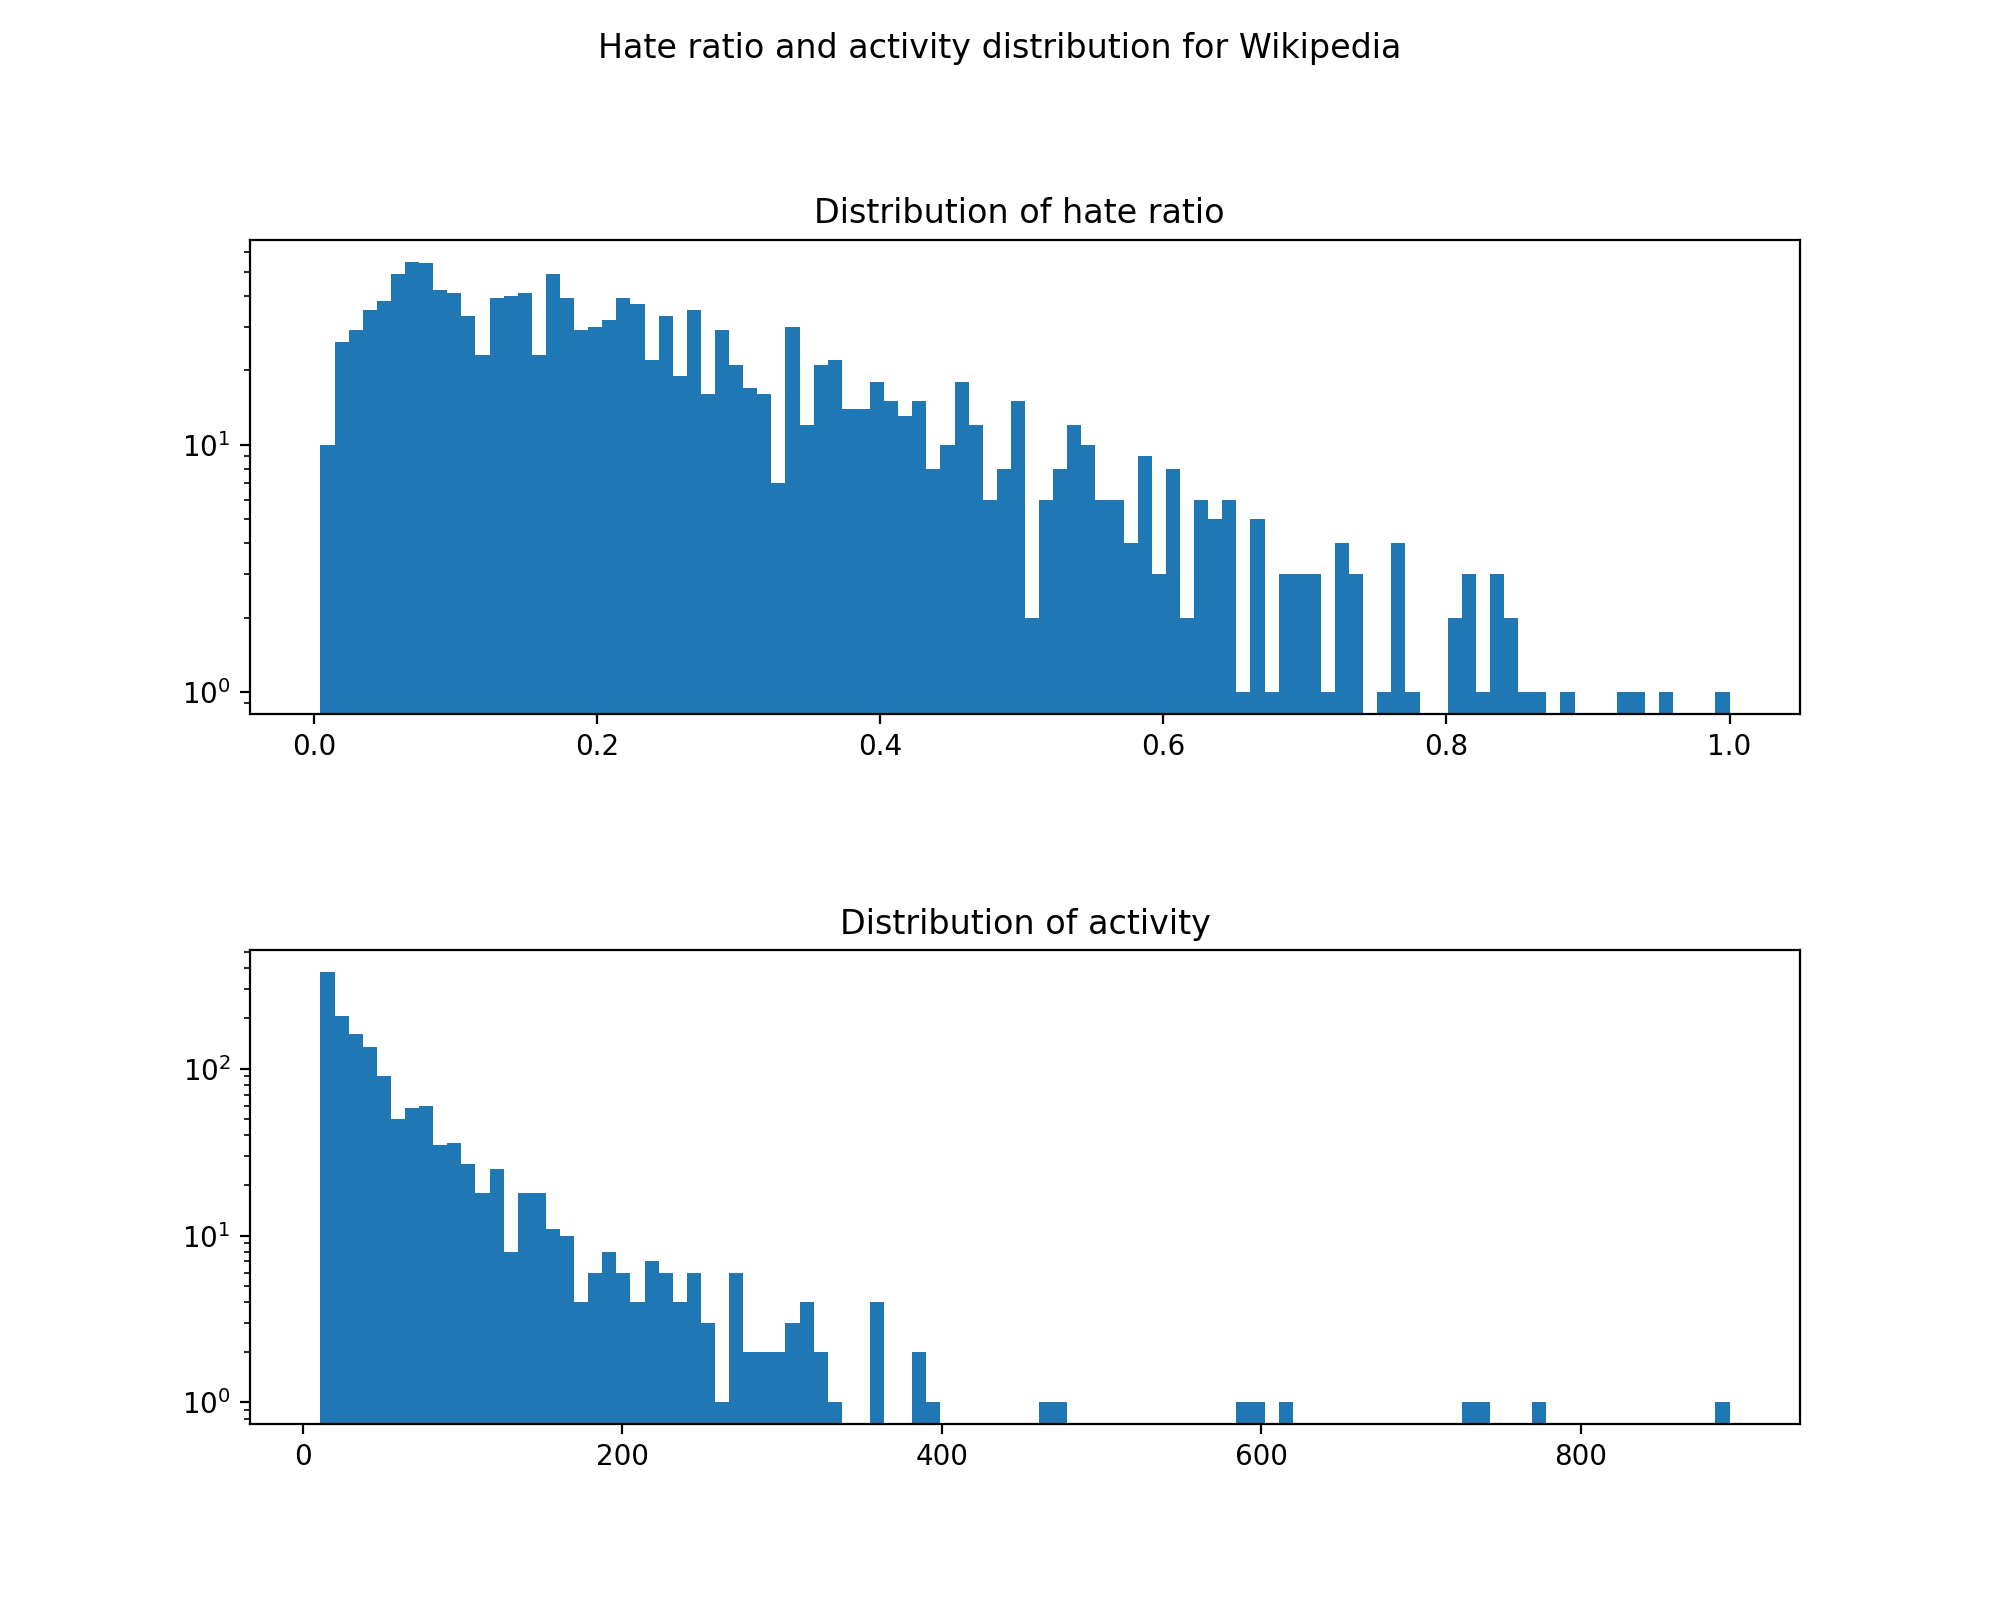

<IPython.core.display.Javascript object>


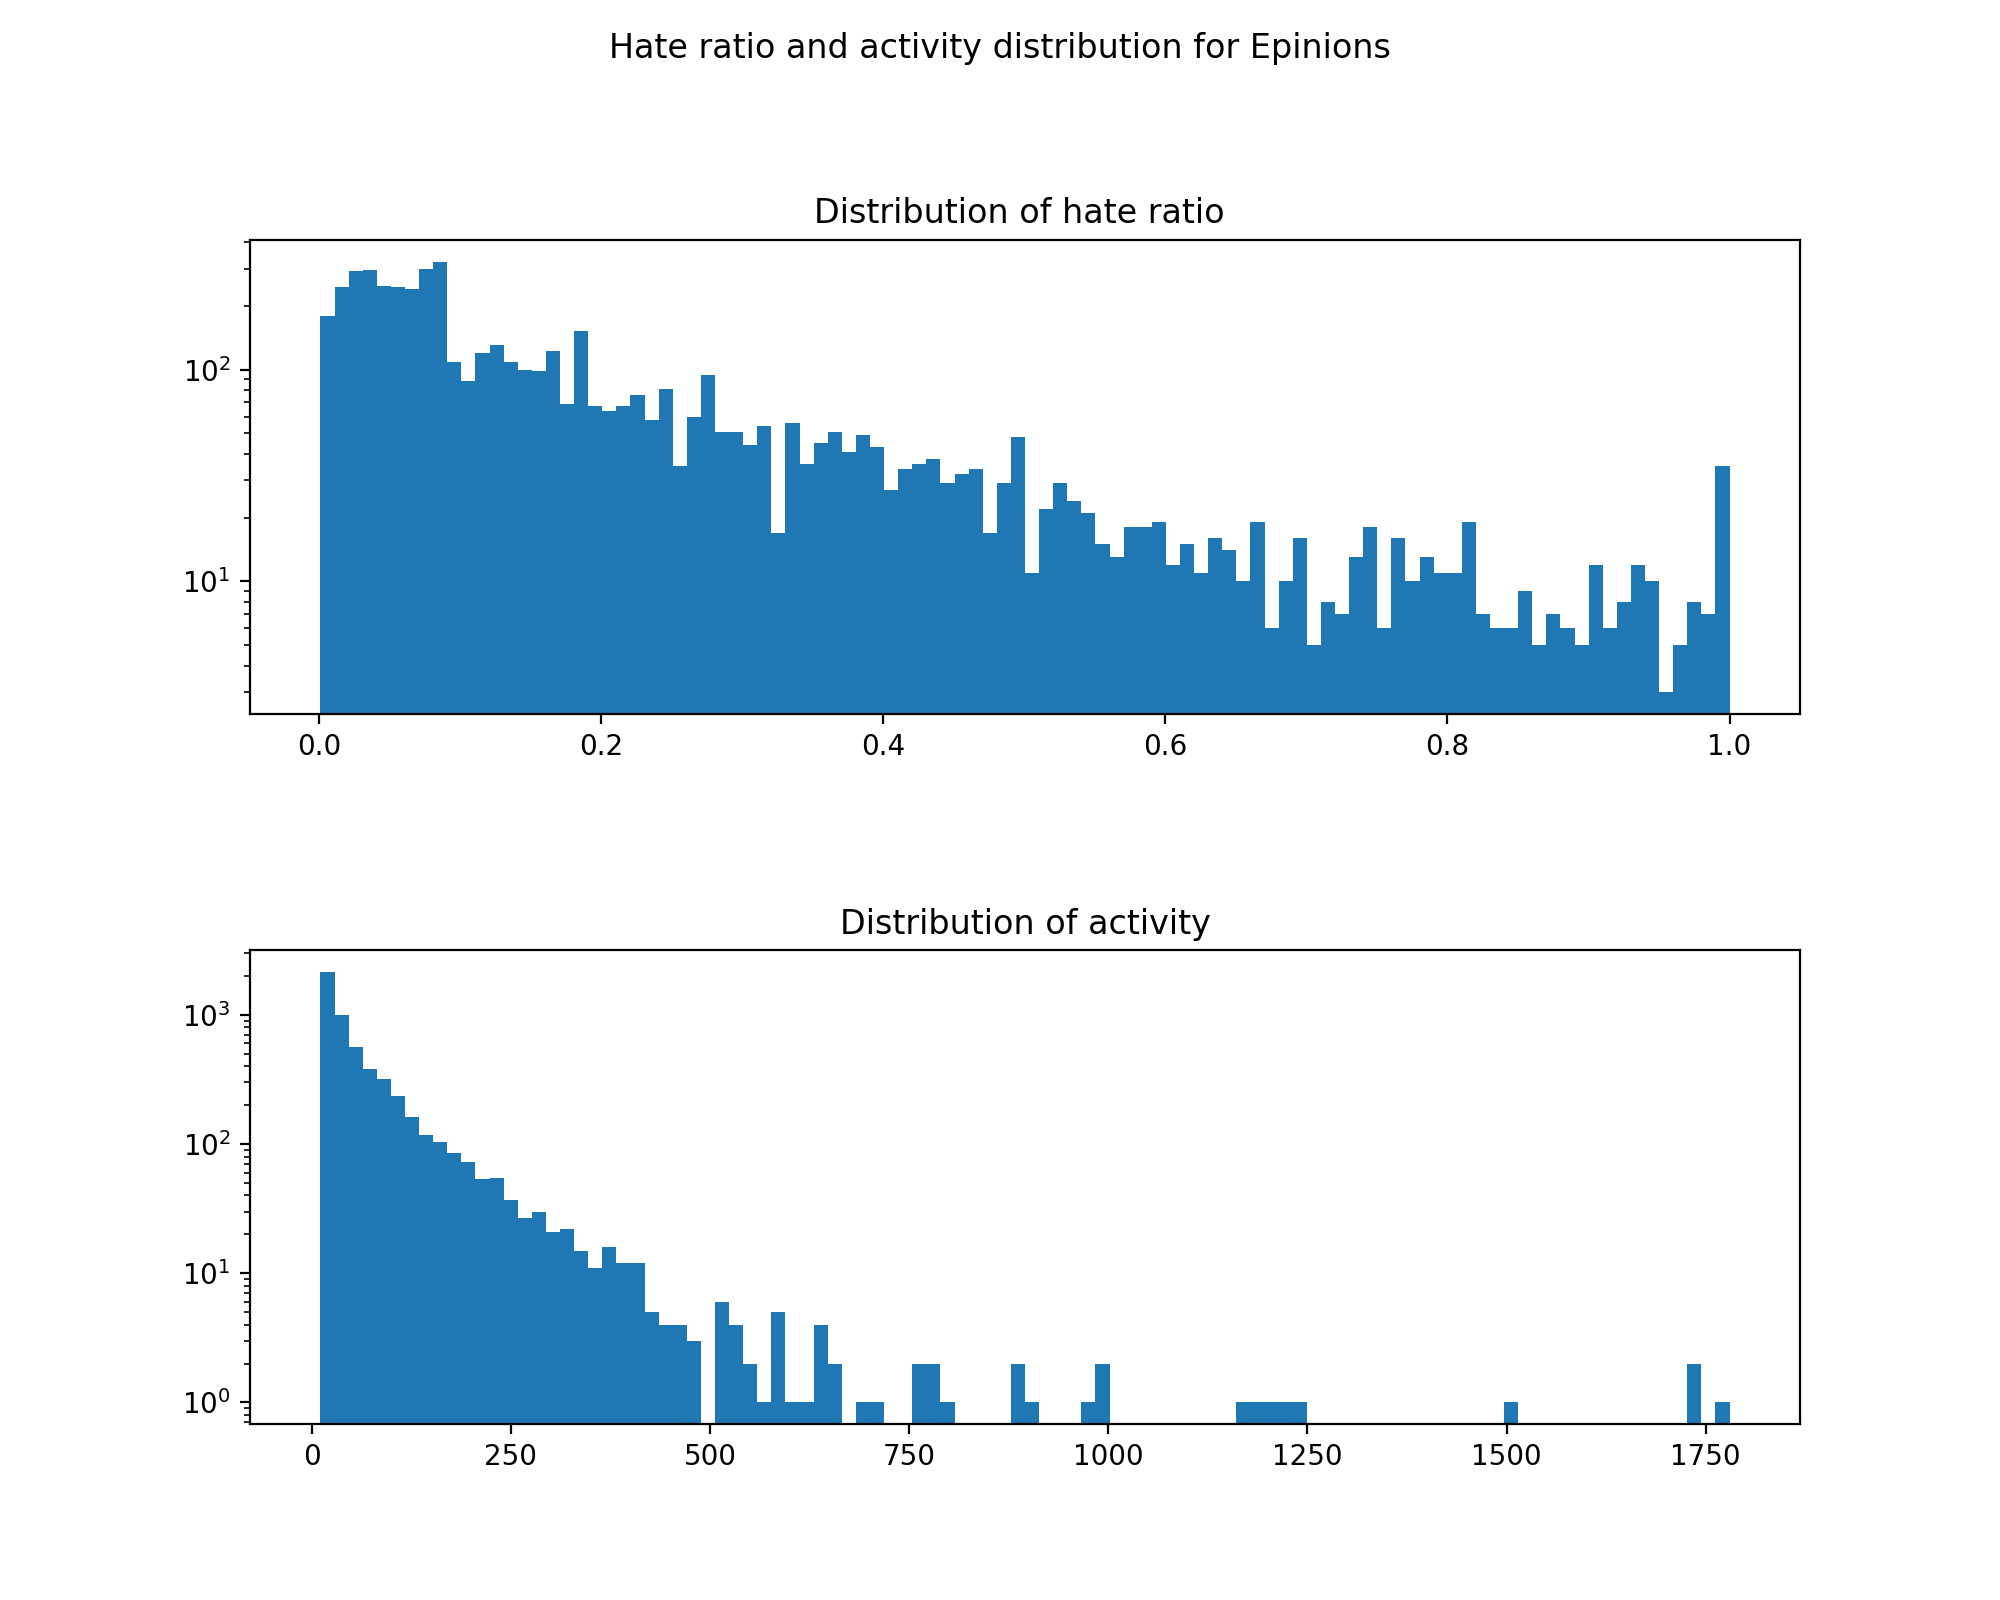

<IPython.core.display.Javascript object>


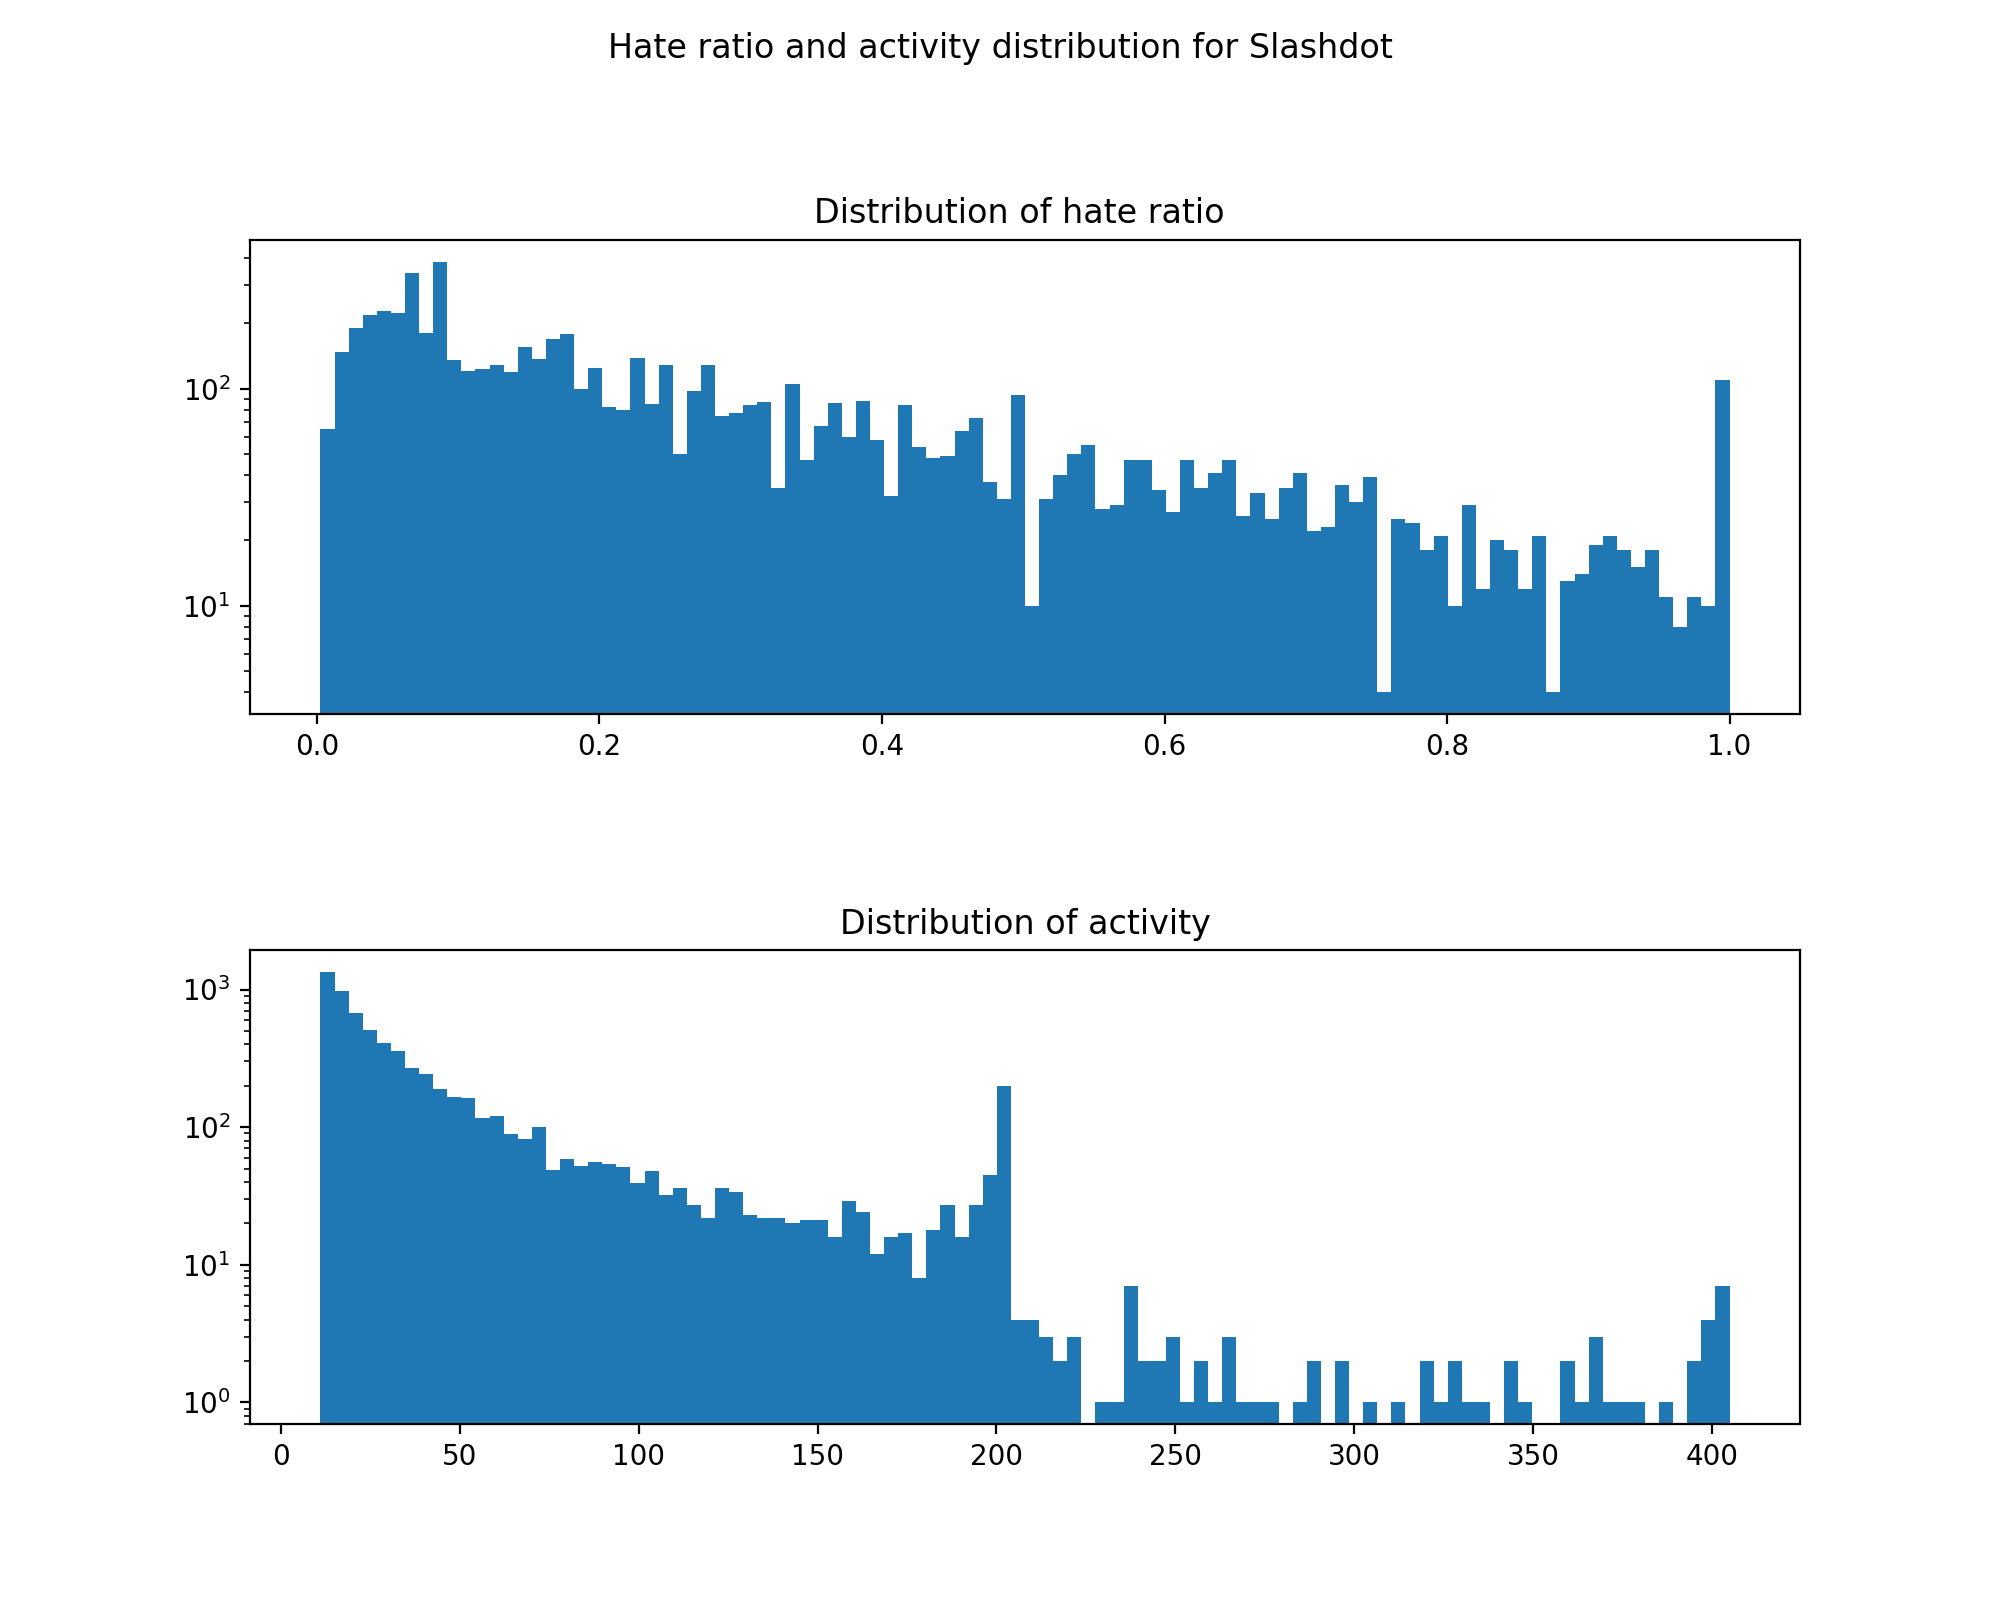

In [30]:
def plot_haters(dataset):
    haters = dataset['source']
    haters = haters[(haters.total_reviews > 10) & (haters.hater != 0)]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,8))
    fig.suptitle(f'Hate ratio and activity distribution for {dataset["name"]}')

    ax1.hist(data=haters, x='hater', bins=100)
    ax1.set_title("Distribution of hate ratio ")
    ax1.set_yscale('log')

    ax2.hist(data=haters, x='total_reviews', bins=100)
    ax2.set_title("Distribution of activity")
    ax2.set_yscale('log')


    plt.subplots_adjust(top = 0.85, hspace=0.5)
    plt.show()

for d in datasets:
    plot_haters(d)